<a href="https://colab.research.google.com/github/Ezekiah3854/image_restoration/blob/main/image_restoration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Image 1 processed!


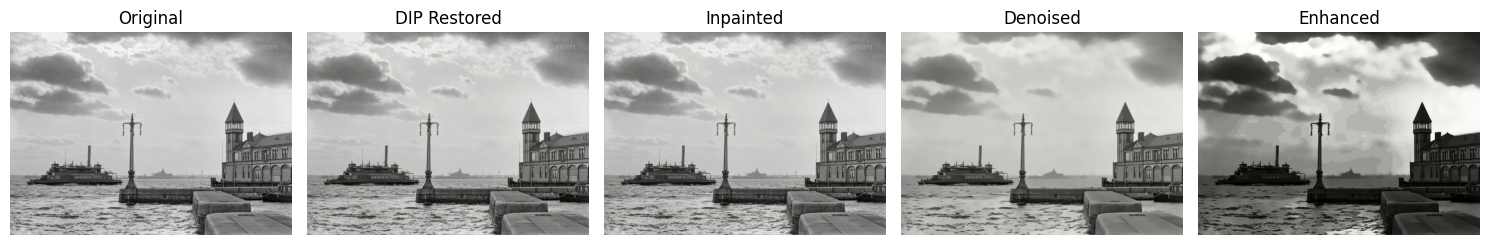

Image 2 processed!


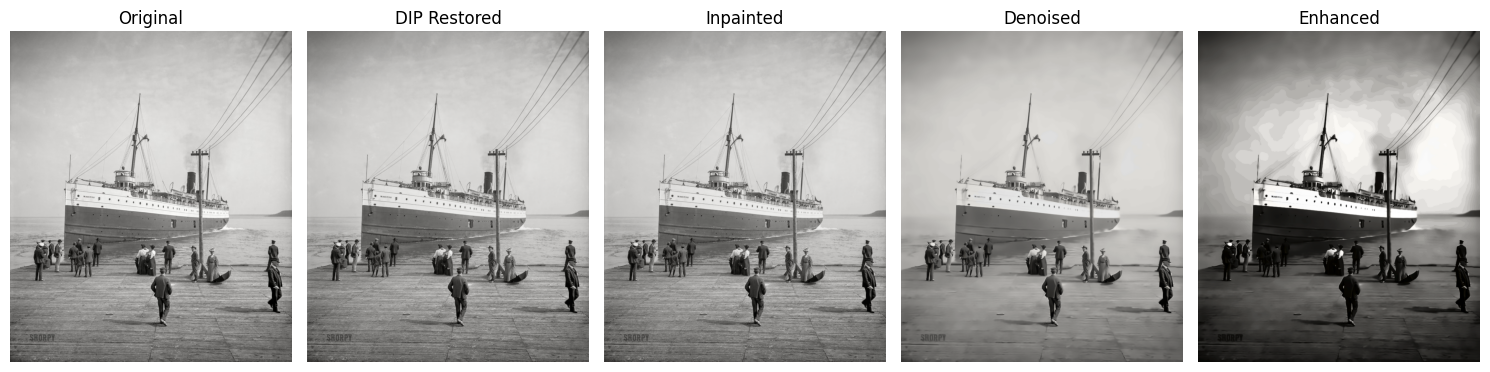

Image 3 processed!


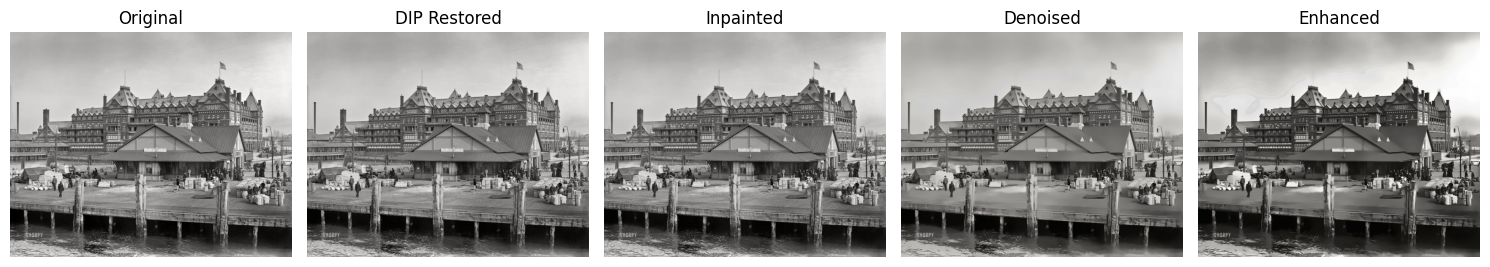

Image 4 processed!


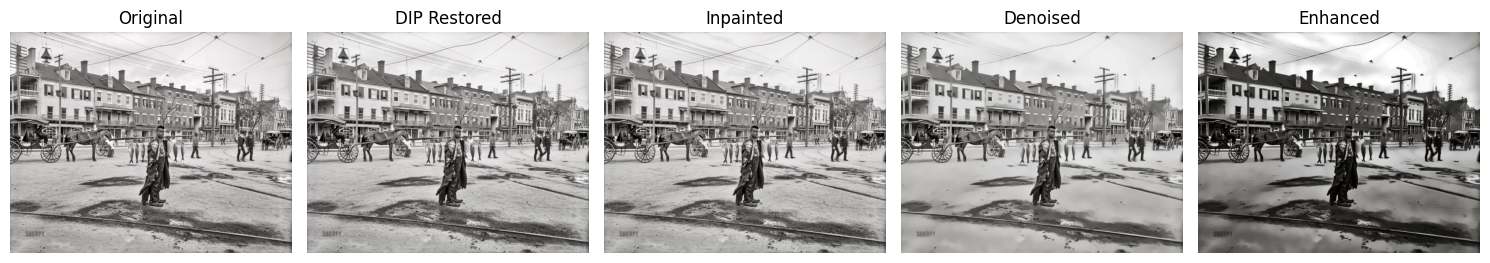

Image 5 processed!


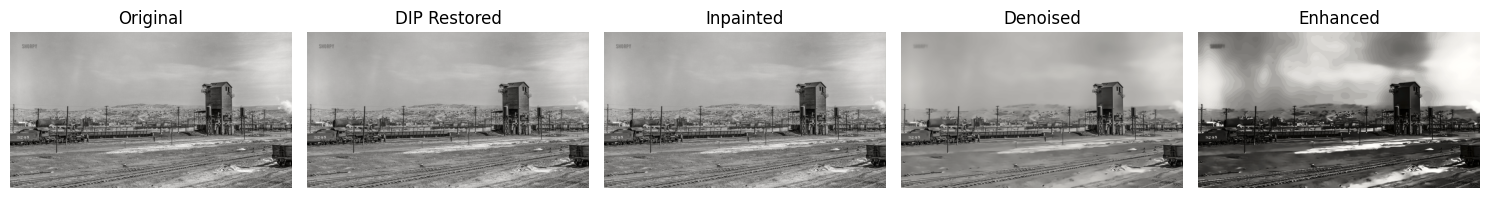

Image 6 processed!


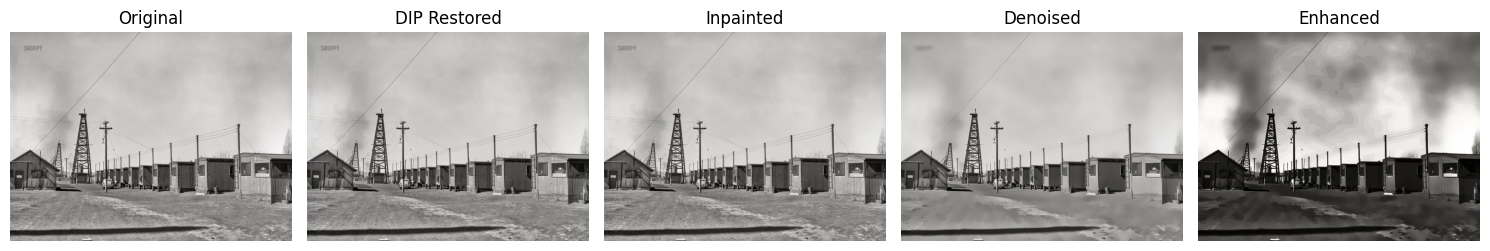

Image 7 processed!


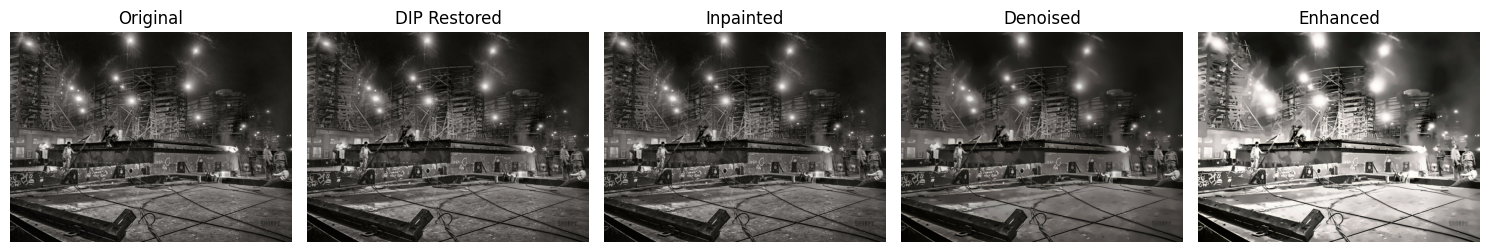

Image 8 processed!


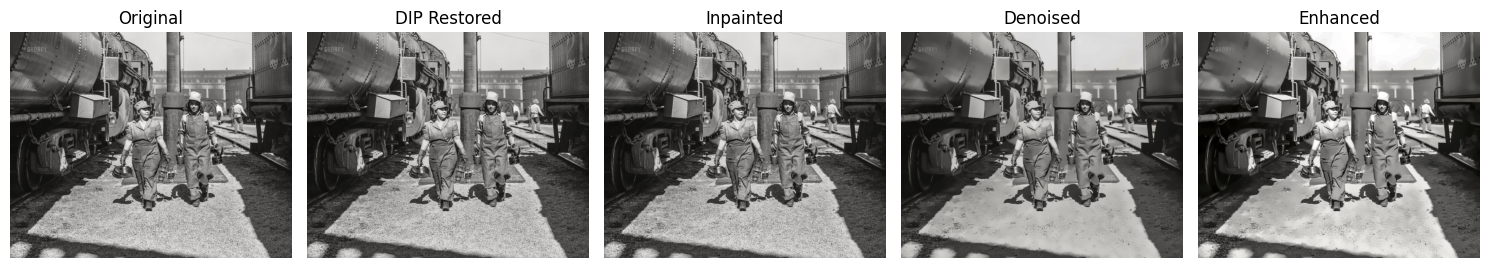

Image 9 processed!


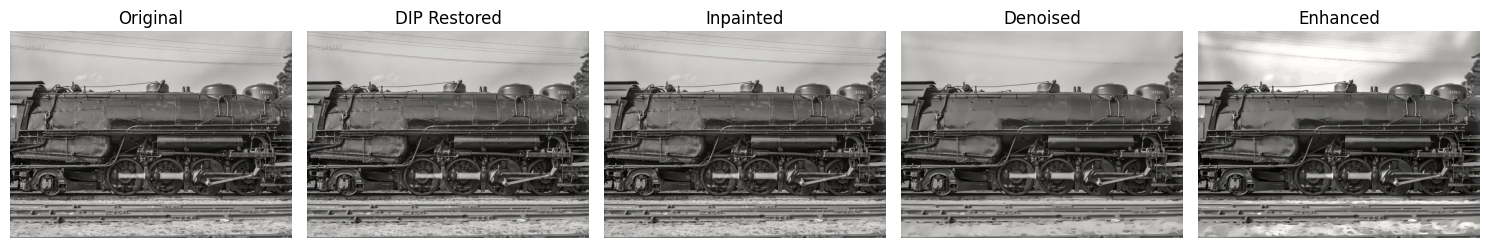

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
from google.colab import drive

drive.mount('/content/drive')

# Define a simple U-Net for DIP
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Load images from folder
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

# Restore image using Deep Image Prior with U-Net

def dip_restore(image):
    # Check if CUDA is available and use it if possible, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet().to(device)  # Move model to the selected device
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    transform = transforms.ToTensor()
    image_tensor = transform(image).unsqueeze(0).to(device)  # Move image tensor to the selected device

    for _ in range(1000):
        optimizer.zero_grad()
        output = model(image_tensor)
        loss = criterion(output, image_tensor)
        loss.backward()
        optimizer.step()

    restored_image = output.squeeze(0).cpu().detach().numpy()
    restored_image = np.transpose(restored_image, (1, 2, 0)) * 255
    restored_image = restored_image.astype(np.uint8)
    return restored_image


# Inpainting damaged areas
def inpaint_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    restored = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)
    return restored

# Noise reduction with Gaussian Blur
def denoise_image(image):
    denoised = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    return denoised

# Contrast adjustment with histogram equalization
def enhance_contrast(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l = cv2.equalizeHist(l)
    enhanced = cv2.merge((l, a, b))
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2BGR)
    return enhanced

# Visual comparison
def compare_images(original, dip_restored, inpainted, denoised, enhanced):
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 5, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 5, 2)
    plt.imshow(cv2.cvtColor(dip_restored, cv2.COLOR_BGR2RGB))
    plt.title("DIP Restored")
    plt.axis("off")

    plt.subplot(1, 5, 3)
    plt.imshow(cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB))
    plt.title("Inpainted")
    plt.axis("off")

    plt.subplot(1, 5, 4)
    plt.imshow(cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB))
    plt.title("Denoised")
    plt.axis("off")

    plt.subplot(1, 5, 5)
    plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
    plt.title("Enhanced")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Main function
def main():
    folder_path = "/content/drive/MyDrive/old images"
    images = load_images(folder_path)

    for i, img in enumerate(images):
        dip_restored = dip_restore(img)
        inpainted = inpaint_image(dip_restored)
        denoised = denoise_image(inpainted)
        enhanced = enhance_contrast(denoised)

        print(f"Image {i + 1} processed!")
        compare_images(img, dip_restored, inpainted, denoised, enhanced)

if __name__ == "__main__":
    main()